## Import required packages 

In [2]:
import pandas as pd 
import numpy as np

import requests

import seaborn as sns

import matplotlib.pyplot as plt

%matplotlib inline

## Extract stock prices for each 

In [3]:
def get_stock_prices(api_key, tckr ): 
    '''
    Input 
    api_key - unique key from polgon.io that you get for signin up
    tckr - the stock that values need to be extracted 

    Ouput 
    df - volume, price, open, close, high and low stock prices for the stock for each day for the previous 2 years 
         (2 years is the maxiumum time span for the free trial of polygon.io )
    '''
    url = f'https://api.polygon.io/v2/aggs/ticker/{tckr}/range/1/day/2023-01-19/2025-01-19?apiKey={api_key}'
    
    response = requests.get(url)
    data = response.json()
    
    # Convert the JSON data to a pandas DataFrame
    df = pd.DataFrame(data['results'])
    
    # Convert the timestamp to a readable date format
    df['t'] = pd.to_datetime(df['t'], unit='ms')
    
    # Display the historical data
    return df

In [4]:
api_key = 'BIf89HTb0NaGQsWozgDr5x1W8GfFC3MH'
# Choose 4 stores that are closest competitors as we can only download 5 a min with the free API 
stocks = ['GLW','APH','DLB','LFUS','ROG']

stock_prices_df = pd.DataFrame([])

for tckr in stocks:
    stock_prices_df_pre = get_stock_prices(api_key, tckr)
    stock_prices_df_pre.columns = [f"{col}_{tckr}" if col != 't' else col for col in stock_prices_df_pre.columns]
    if stock_prices_df.empty:
        stock_prices_df = stock_prices_df_pre
    else:
        stock_prices_df = stock_prices_df.merge(stock_prices_df_pre, on='t', how='outer')

In [5]:
stock_prices_df.head()

,v_GLW,vw_GLW,o_GLW,c_GLW,h_GLW,l_GLW,t,n_GLW,v_APH,vw_APH,...,h_LFUS,l_LFUS,n_LFUS,v_ROG,vw_ROG,o_ROG,c_ROG,h_ROG,l_ROG,n_ROG
0,4697536.0,36.2105,35.97,36.11,36.525,35.872,2023-01-23 05:00:00,41530,4743714.0,39.4718,...,253.27,243.50,3744,289683.0,132.1434,133.00,132.23,133.26,131.3600,6597
1,3469967.0,35.9481,36.05,35.81,36.205,35.480,2023-01-24 05:00:00,34870,4968706.0,39.7341,...,255.46,247.60,3773,209051.0,131.3895,132.10,131.20,132.53,130.4648,4464
2,4334809.0,35.4321,35.49,35.56,35.640,35.025,2023-01-25 05:00:00,39349,7761076.0,39.1836,...,251.71,246.31,3401,296371.0,131.9778,130.00,133.60,134.47,129.3600,5950
3,4777904.0,36.2280,35.72,36.43,36.440,35.720,2023-01-26 05:00:00,51171,5834620.0,39.1989,...,254.13,246.50,4826,228450.0,134.5502,133.45,135.36,135.41,132.9000,4868
4,4588693.0,36.8311,36.33,36.80,37.040,36.295,2023-01-27 05:00:00,41879,5188690.0,39.2769,...,256.37,250.20,3688,178757.0,135.9170,134.76,136.57,136.57,134.7600,5286


## See if any data is missing 

In [6]:
stock_prices_df.isna().sum().sum()

np.int64(0)

In [7]:
stock_prices_df.isin([np.inf, -np.inf]).sum().sum()

np.int64(0)

In [8]:
# No missing data, all has been pulled through from the API 

## Explore the data 

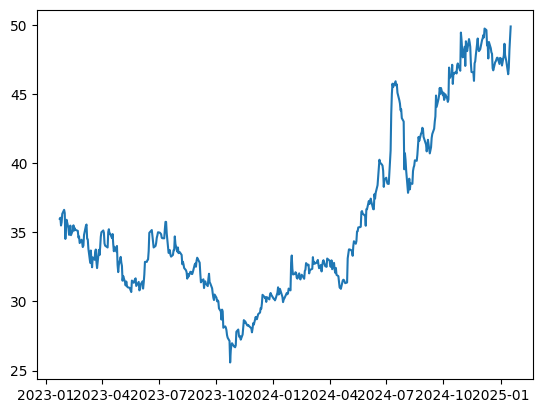

In [9]:
# look at trend over time 
plt.plot(stock_prices_df['t'],stock_prices_df['o_GLW'])

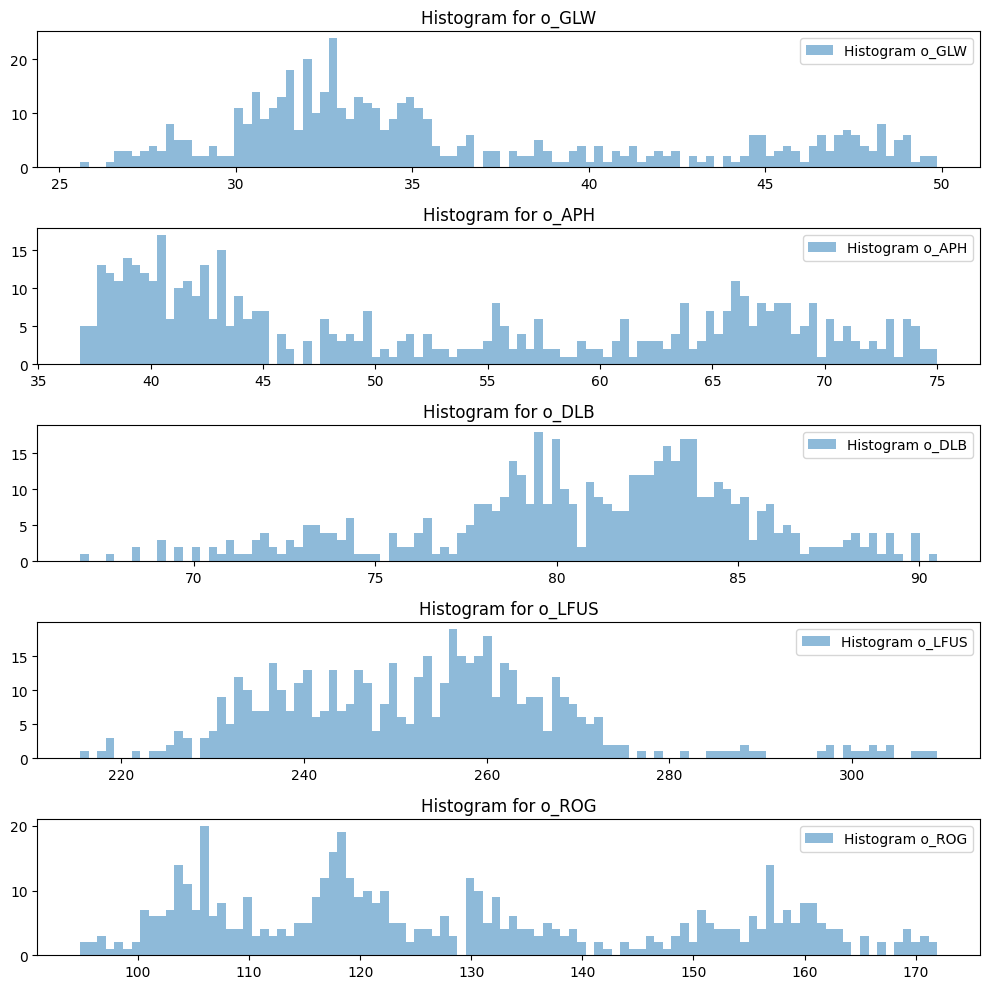

In [10]:
# Most stocks are not normally distributed so make sure methods do not include this 
fig, axs = plt.subplots(5, 1, figsize=(10, 10))

for i, tckr in enumerate(stocks[:5]):
    tckr = 'o_' + tckr 
    axs[i].hist(stock_prices_df[tckr], bins=100, alpha=0.5, label=f'Histogram {tckr}')
    axs[i].set_title(f'Histogram for {tckr}')
    axs[i].legend()

plt.tight_layout()
plt.show()

## Auto regression 
Understand if previous values in previous time series contribute to fucture 

In [38]:
def autocorrelation_check(df, target_col, col, min_lag=5, max_lag=50):
    correlations = []
    lagged_cols = {}
    for lag in range(min_lag, max_lag + 1):
        lagged_cols[f'{col}_lagged_{lag}'] = df[col].shift(lag)
    
    lagged_df = pd.DataFrame(lagged_cols)
    target_series = df[target_col]
    
    for lag in range(min_lag, max_lag + 1):
        correlation = target_series.corr(lagged_df[f'{col}_lagged_{lag}'])
        correlations.append({'lag': lag, 'correlation': correlation})
    
    correlation_df = pd.DataFrame(correlations)
    return correlation_df

def generate_top_correlations(df, target_col='o_GLW', min_lag=5, max_lag=6):
    all_correlations = []
    for col in df.columns:
        if col == 't' or col == target_col:
            continue
        correlation_df = autocorrelation_check(df, target_col, col, min_lag, max_lag)
        correlation_df['column'] = col
        all_correlations.append(correlation_df)
    
    all_correlations_df = pd.concat(all_correlations)
    
    # Get the top one correlation from each column by magnitude
    top_correlations = all_correlations_df.loc[all_correlations_df.groupby('column')['correlation'].apply(lambda x: x.abs().idxmax())]
    
    return top_correlations

In [47]:
top_corr_columns = generate_top_correlations(stock_prices_df,max_lag = 28 * 6)['lag']

In [49]:
def plot_correlations(df, target_col='o_GLW', min_lag=5, max_lag=50):
    for col in df.columns:
        if col == 't' or col == target_col:
            continue
        correlation_df = autocorrelation_check(df, target_col, col, min_lag, max_lag)
        plt.figure(figsize=(10, 2))
        plt.plot(correlation_df['lag'], correlation_df['correlation'], marker='o')
        plt.title(f'Lag vs Correlation for {col}')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')
        plt.grid(True)
        plt.show()

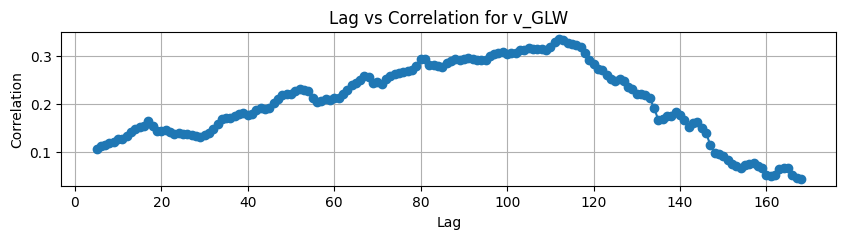

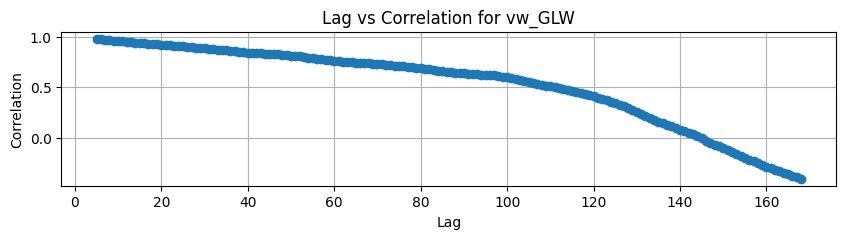

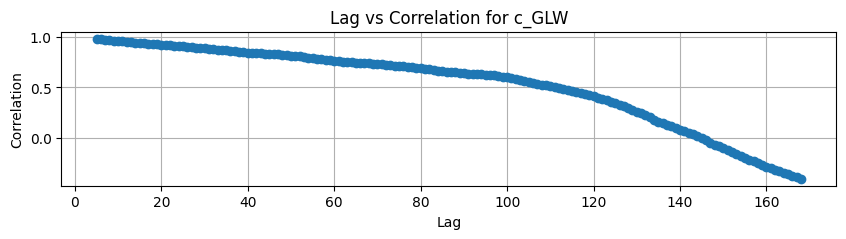

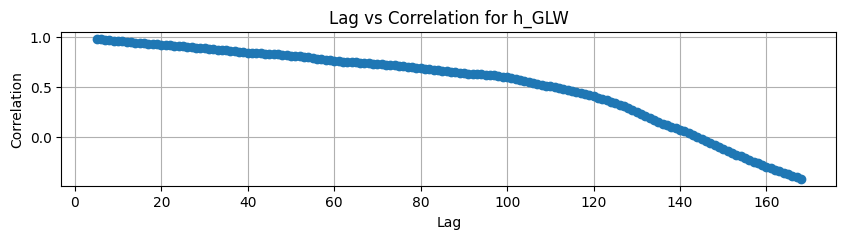

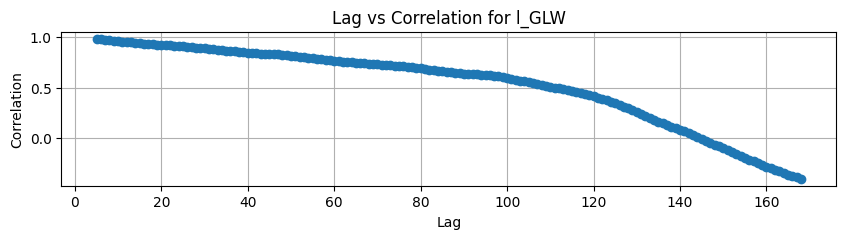

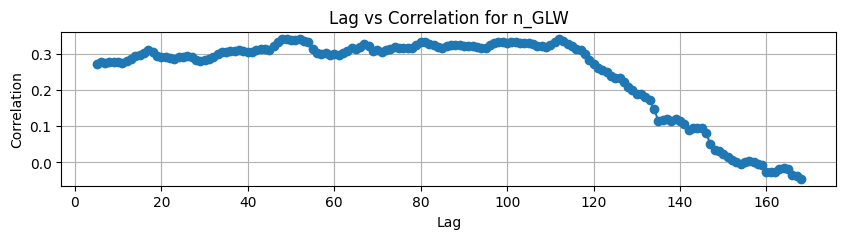

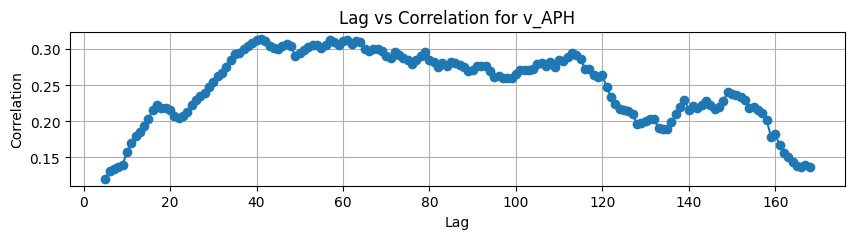

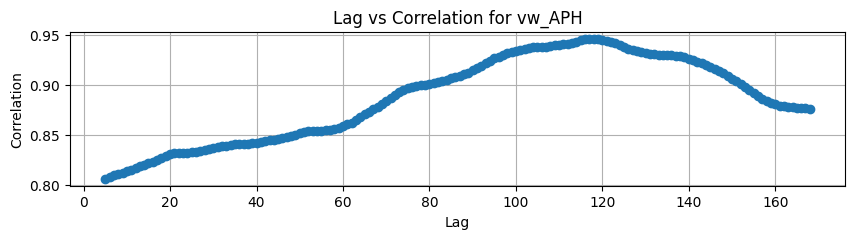

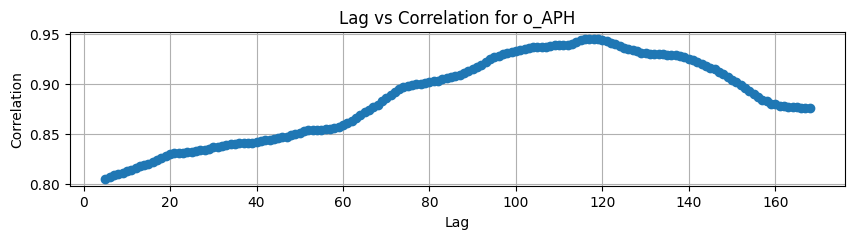

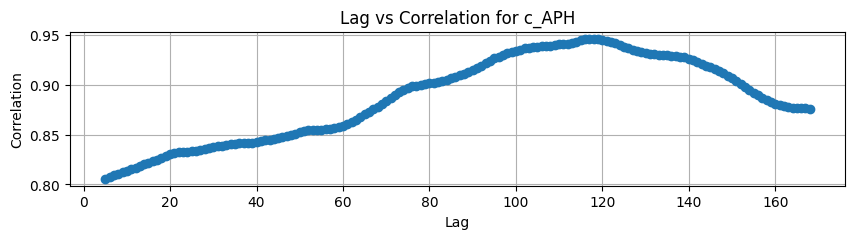

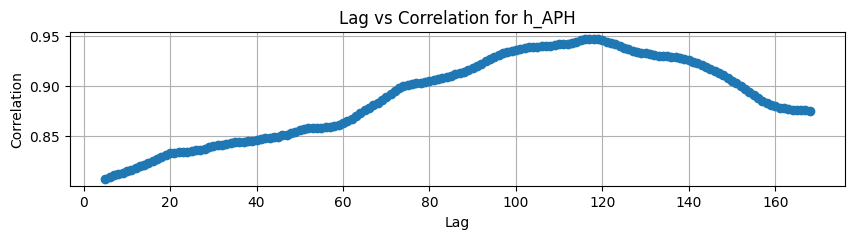

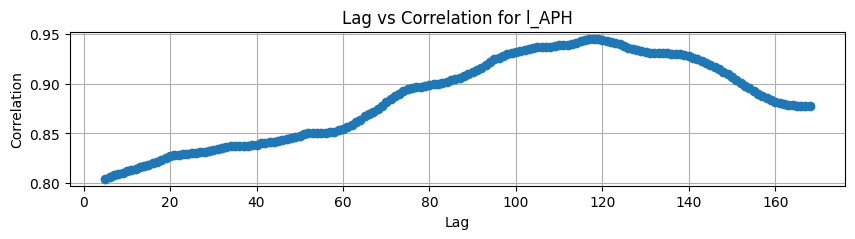

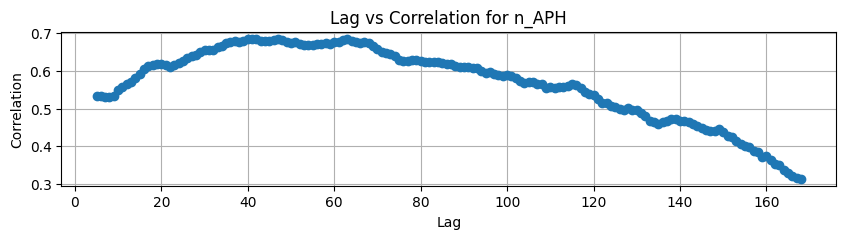

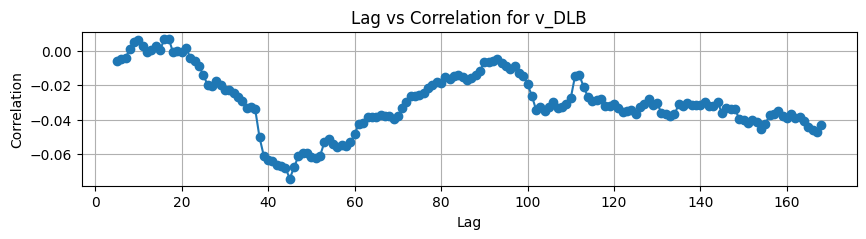

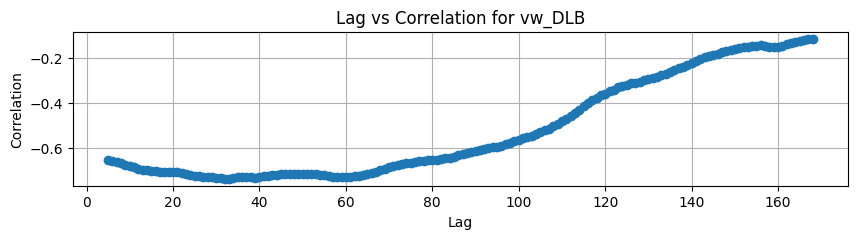

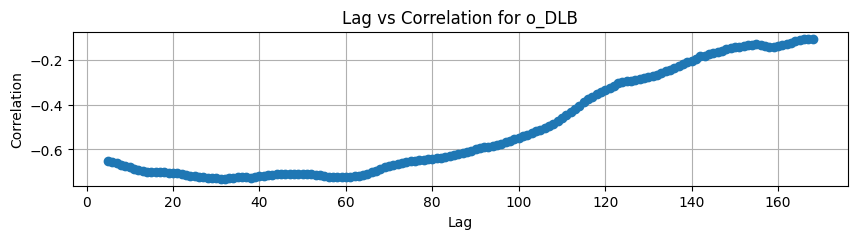

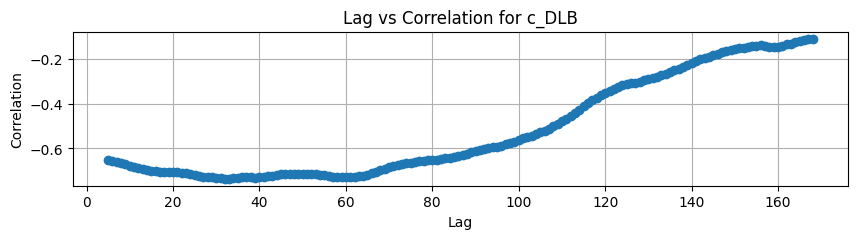

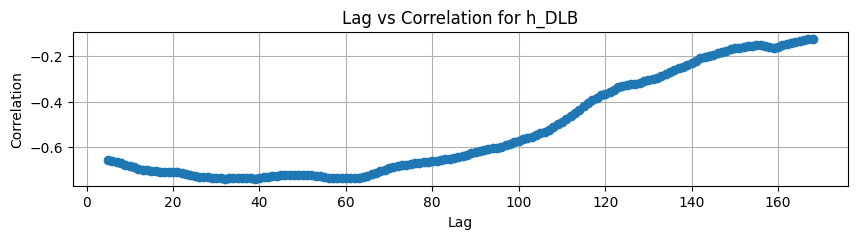

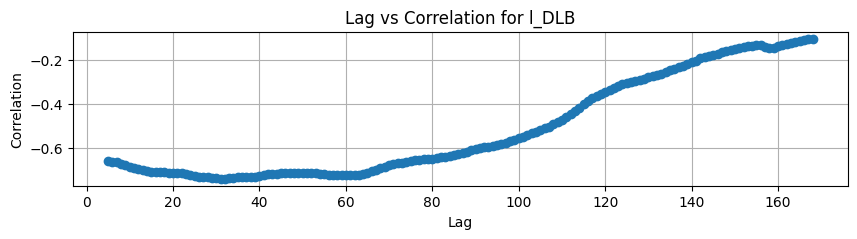

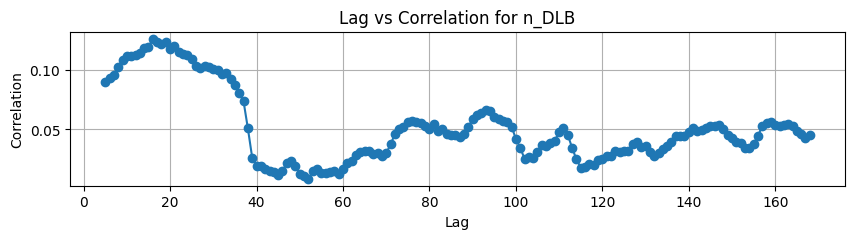

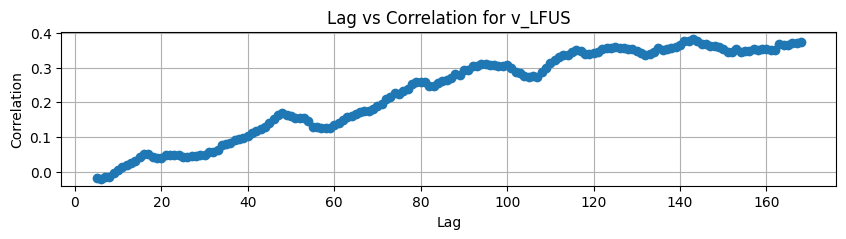

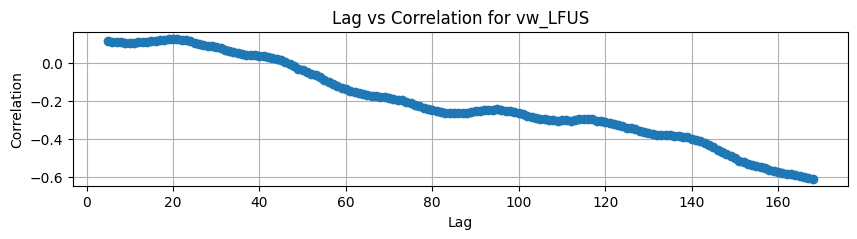

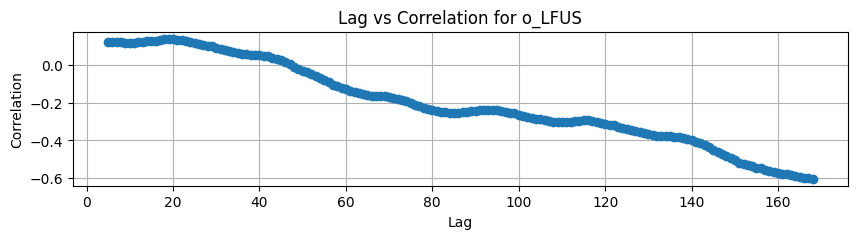

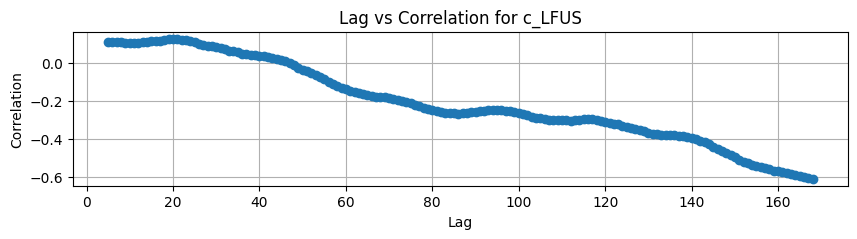

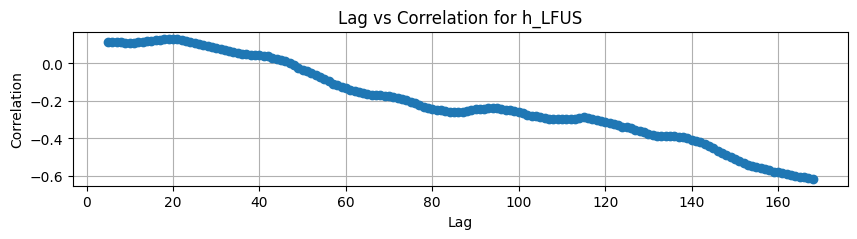

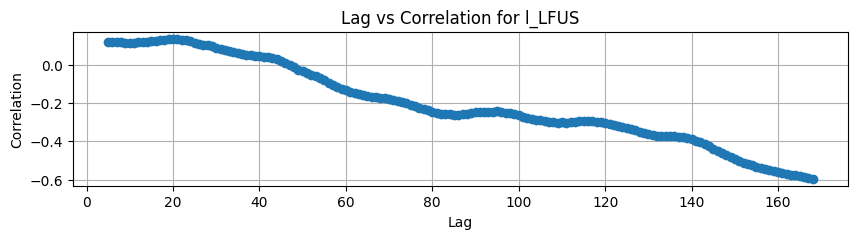

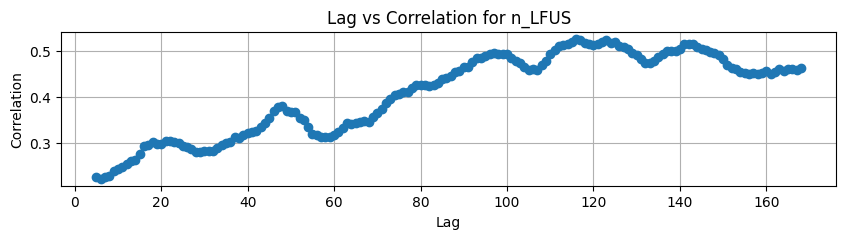

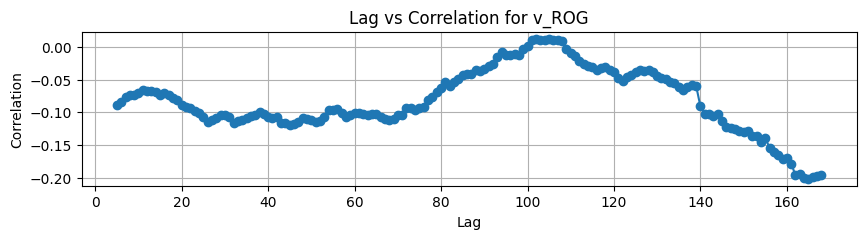

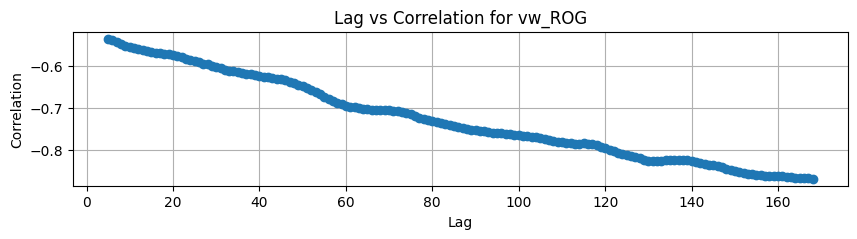

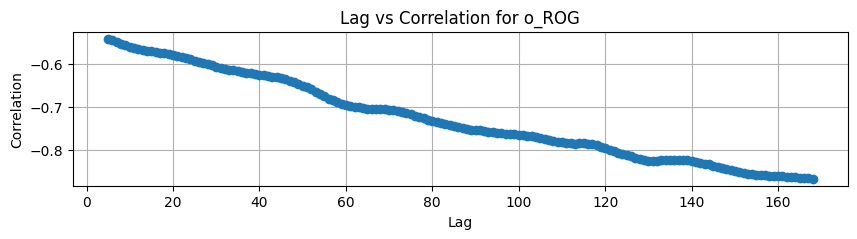

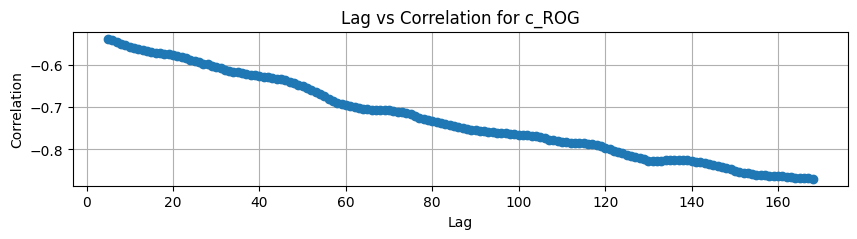

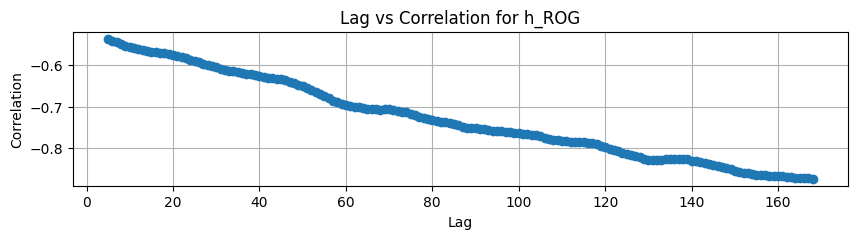

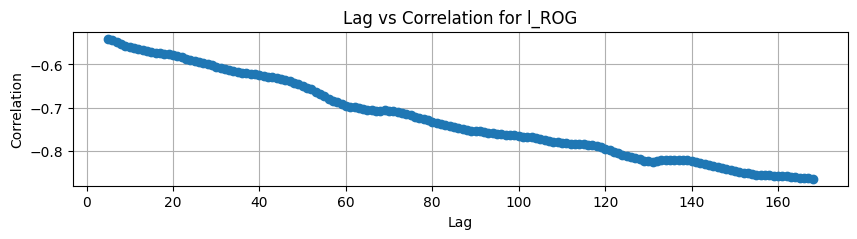

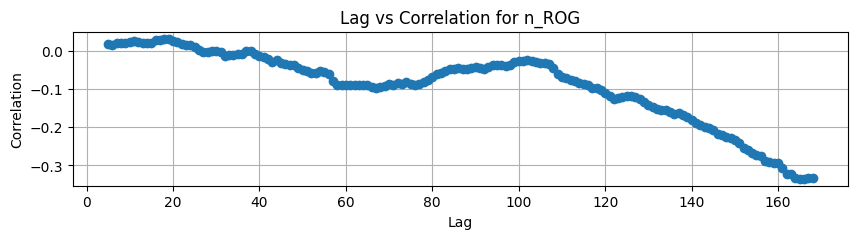

In [50]:
# Only a few double peaks so maxiumum can be used
plot_correlations(stock_prices_df,max_lag = 28 * 6)

## References 
- https://polygon.io/ - used to pull in stock prices 
- https://www.marketbeat.com/stocks/NYSE/GLW/competitors-and-alternatives/#:~:text=The%20main%20competitors%20of%20Corning,%2C%20and%20ARM%20(ARM). - Corning competitors